In [1]:
#!/usr/bin/env python3
# coding=utf-8
# Search for pulsations using the Z statistic
import sys
import matplotlib.pyplot as plt
import numpy as np
import argparse
from matplotlib.gridspec import GridSpec
import multiprocessing as mp
from operator import attrgetter
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from stingray.pulse.pulsar import fold_events, fold_detection_level, z2_n_detection_level
from stingray.pulse.search import plot_profile, epoch_folding_search, z_n_search, search_best_peaks
from timing_analysis.lightcurves.load import load_ligth_curve
import logging
import os
import time
from matplotlib.ticker import FuncFormatter
from astropy.io import fits
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib qt

In [2]:
def load_ligth_curve(lightcurve):
    """Load lightcurve from fits file. Returns the time counts and errors."""
    print('Reading fits file %s' % lightcurve)
    hdulist = fits.open(lightcurve)
    data = hdulist[1].data
    gti = hdulist[2].data
    head = hdulist[1].header
    hdulist.close()

    telescope = head['TELESCOP']
    time_res = head['TIMEDEL']
    times = data[:]['TIME']
    error = data[:]['ERROR']
    cts = data[:]['RATE']
    gti_start = gti[:]["START"]
    gti_stop = gti[:]["STOP"]
    gti = np.array([(gti_segment_start, gti_segment_stop) for gti_segment_start, gti_segment_stop
                   in zip(gti_start, gti_stop)])
    # set Nan values filtered by the GTI to 0
    valid_counts = np.where(np.isfinite(cts) != True)

    cts[valid_counts] = 0
    error[valid_counts] = 0

    # Nustar lightcurves are set at T = 0
    if telescope == 'NuSTAR':
        print("Reading Nustar lightcurve")
        times += head['TSTART']

    print("Lightcurve start time %.3f s" % times[0])
    print("Lightcurve time resolution %.3f s" % time_res)
    duration = times[-1] - times[0]
    print("Lightcurve duration %.3f s" % duration)
    return times, cts, error, time_res, gti
def plot_lc(lc, ax='None', err=0, label="", rebin_seconds=1000):
    if rebin_seconds>1:
        lc_plot = lc.rebin(rebin_seconds * lc.dt)
    else:
        lc = lc_plot
    time = lc_plot.time
    cts = lc_plot.counts
    std = lc_plot.counts_err
    mean_counts = lc_plot.meancounts
    if ax=='None':
        plt.errorbar(time, cts, yerr=std, fmt='o',ls="-",
                     linewidth=0.5,elinewidth=0.5,markersize=1,errorevery=10,label="%s" %label)
        plt.axhline(y=mean_counts , color="black",  ls="--")
    else:
        ax.errorbar(time, cts, yerr=std, fmt='o',ls="-",
                     linewidth=0.5,elinewidth=0.5,markersize=1,errorevery=10,label="%s" %label)
        ax.axhline(y=mean_counts, color="black", ls="--")
    
def search_period(central_period, lc, fdots, samples=200, oversampling=10, nbin=30, nharm=3):
    # n bin always 10 times of harmonics
    print("Oversampling used %d" %oversampling)
    print("Number of bins: %d" %nbin)
    print("Number of harmonics %d" %nharm)
    df_min = 1 / lc.tseg
    df = df_min / oversampling
    #frequencies = np.linspace(1 / central_period - samples * df,  1 / central_period + samples * df, samples)
    frequencies = np.arange(1 / central_period - samples * df, 1 / central_period + samples * df, df)
    print("Range of periods to be probed: %.5f - %.5f sampled at %.7f s" %(1/frequencies[0], 1/frequencies[-1], df))
    print("Range of period derivatives to be probed: %.2E - %.2E" %(fdots[0], fdots[-1]))
    ntrials = len(frequencies)*len(fdots)
    print("Running Z search with %d X %d (=%d) frequencies and frequency derivatives..." % (len(frequencies), len(fdots), ntrials))
    start = time.process_time()
    fgrid, fdgrid, zstat = z_n_search(lc.time, frequencies, nbin=nbin, nharm=nharm, fdots=fdots)
    print("Done in %.5f min for %d trials" %(((time.process_time() - start)/60, ntrials)))
    return fgrid, fdgrid, zstat

In [9]:
common_dir = "/home/agurpide/x_ray_data"
source='M81-X6'
obs="0111800101"
instrument="outputpn"
os.chdir("%s/%s/%s/%s/lightcurves/0.0058" %(common_dir, source, obs, instrument))
input_lc = "PN_source_corr_broadband.lc"

In [10]:
times, cts, std, time_res, gti = load_ligth_curve(input_lc)
# the power spectra breaks when setting the GTI
ligth_curve = Lightcurve(times, cts, input_counts=False, err=std, gti=gti)

Reading fits file PN_source_corr_broadband.lc
Lightcurve start time 104322446.697 s
Lightcurve time resolution 0.006 s
Lightcurve duration 129733.083 s


Lightcurve 0 duration 6221.46
Lightcurve 1 duration 5399.29
Lightcurve 3 duration 40614.91
Lightcurve 4 duration 1588.62
Lightcurve 6 duration 1356.74
Lightcurve 10 duration 7863.19
Lightcurve 11 duration 13497.99
Lightcurve 12 duration 1499.91
Lightcurve 16 duration 2999.82
Lightcurve 24 duration 1999.89
Lightcurve 25 duration 5799.66
Lightcurve 49 duration 1399.92
Lightcurve 50 duration 1099.94
Lightcurve 51 duration 2399.87
Lightcurve 52 duration 2899.83


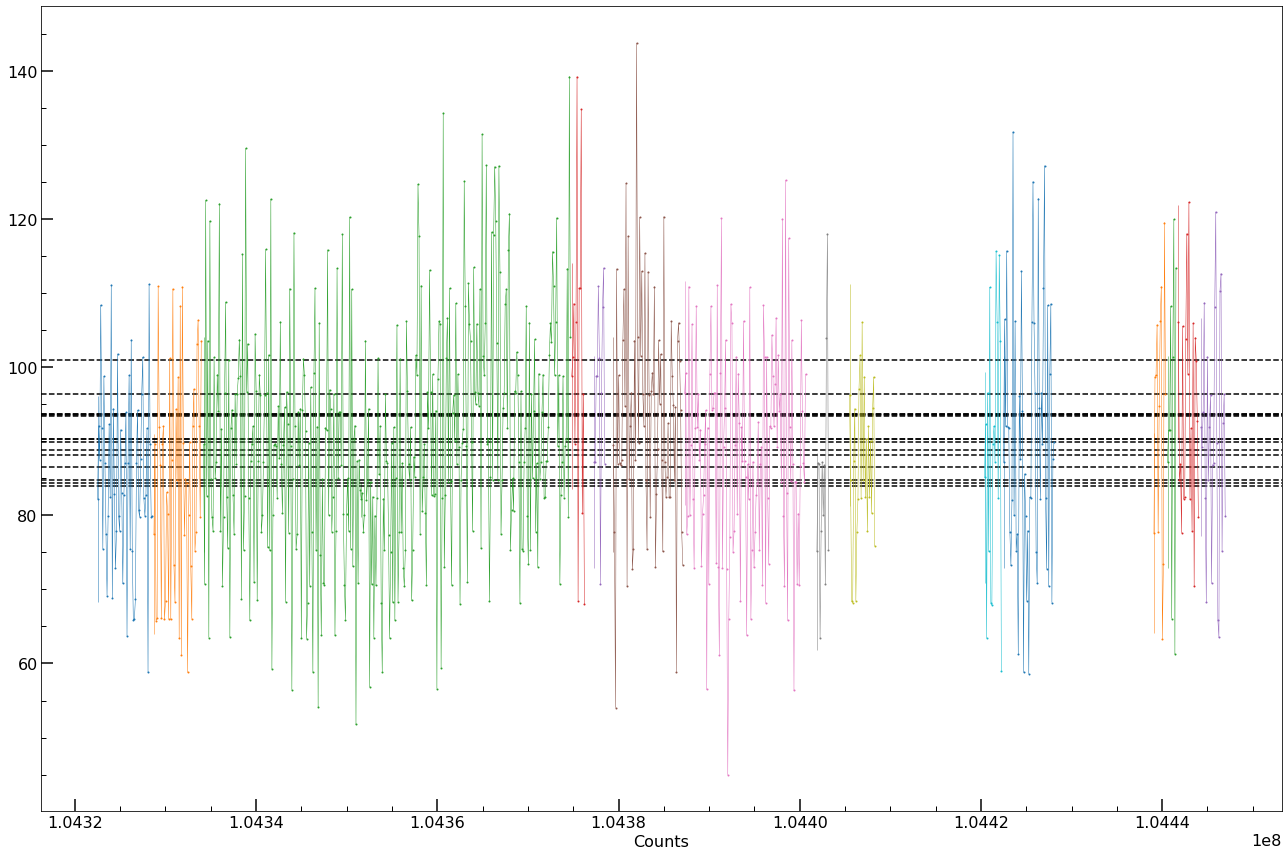

In [15]:
lcs = ligth_curve.split_by_gti(min_points=100)
figure_lcs, lc_ax = plt.subplots(figsize=(18, 12))
for index, lc in enumerate(lcs):
        if lc.tseg>1000:
            plot_lc(lc, ax=lc_ax, rebin_seconds=20000)
            lc.write(input_lc.replace(".lc","split_gti_%d.nc" %index), format="hdf5")
            print("Lightcurve %d duration %.2f" %(index, lc.tseg))
lc_ax.set_xlabel("Seconds")
lc_ax.set_xlabel("Counts")
figure_lcs.savefig("lc_split_gti.png")

In [6]:
# keep lightcurves with a minimum seconds duration
min_t = 10000
lcs = np.array([lc for lc in lcs if lc.tseg>min_t])
print("Keeping %d lightcurves with minimum duration %d" %(len(lcs), min_t))

Keeping 2 lightcurves with minimum duration 10000


In [ ]:
# rebin lightcurves
time_bins = 4
lcs = np.array([lc.rebin(time_bins * lc.dt) for lc in lcs])

In [8]:
# do power spectra
rebin_powspec = 0
power_figure, pow_ax = plt.subplots(figsize=(18, 12))
cumulative_figure, cumulative_ax = plt.subplots(figsize=(18, 12))
cumulative_ax.set_xlabel("Power")
cumulative_ax.set_yscale("log")
cumulative_ax.set_ylabel("Distribution")
hist_bins = 50
# plot the cumulative histogram

pow_ax.set_xlabel("Frequency (Hz)")
pow_ax.set_xscale("log")
pow_ax.set_ylabel("Powers")
pow_ax.axhline(y=2, label="Poissonian level", color="black", ls="solid")
# ntrials = N powers
# NPSD = number of power spectrum (see Israel presentation)
npsd = 1
dof = 2 * npsd
chi_square_dist = np.random.chisquare(dof, 1000)
cumulative_ax.hist(chi_square_dist, hist_bins, 
                                          density=True, histtype='step',
                           cumulative=-1, label='$\chi^2$', color="black")
for lc_index, lc in enumerate(lcs):
    print("Lightcurve duration %.2f" %lc.tseg)    
    #lc_ax.errorbar(lc.time - lc.tstart, lc.countrate, yerr=lc.countrate_err, linewidth=0.5, marker='o', ms=2, errorevery=10, label="%.2f - %.2f" %(lc.tstart, lc.time[-1]), drawstyle='steps-mid')
    print("Computing power spec for lightcurve %d" % lc_index)
    pow_spec = Powerspectrum(lc, norm='leahy')
    print("Frequency resolution %.2E"% pow_spec.df)
    
    if rebin_powspec==1:
        pow_spec = pow_spec.rebin_log(f=0.02)
        errors = 2 / np.sqrt(pow_spec.m[1:-1])
        
    else:
        errors = yerr=2 / np.sqrt(pow_spec.m)

    ntrials = len(pow_spec.power)
    p_threshold = - 2 * np.log(0.003/ (ntrials * npsd))

    pow_ax.axhline(y=p_threshold, label="3 $\sigma$", ls="--", color="green")                          
    pow_ax.errorbar(pow_spec.freq[1:-1], pow_spec.power[1:-1], yerr=errors, ls="-",linewidth=1, elinewidth=0.8, markersize=4, 
                    errorevery=1000, drawstyle='steps-mid', label="%.2f - %.2f" %(lc.tstart, lc.time[-1]))
    max_index = np.argmax(pow_spec.power[1:-1])
    freq_max = pow_spec.freq[1:-1][max_index]
    cumulative_ax.hist(pow_spec.power, hist_bins, 
                                          density=True, histtype='bar',
                           cumulative=-1, label='Raw data', color="blue")

    cumulative_ax.axvline(x=p_threshold, label="3 $\sigma", color="green")
    print("Power spec maximum %d with frequency (period): %.2E (%.2E)" %(np.max(pow_spec.power[1:-1]), freq_max, 1/freq_max))
pow_ax.legend(loc='right')
plt.legend()
cumulative_figure.savefig("cumulative_distribution.png")
power_figure.savefig("cumulative_distribution.png")

Lightcurve duration 40614.91
Computing power spec for lightcurve 0
Frequency resolution 2.46E-05
Power spec maximum 70 with frequency (period): 3.50E+01 (2.86E-02)
Lightcurve duration 13497.99
Computing power spec for lightcurve 1
Frequency resolution 7.41E-05
Power spec maximum 71 with frequency (period): 7.62E+01 (1.31E-02)


In [10]:
mean_power = np.mean(pow_spec.power)
print(mean_power)

4.710824


In [16]:
best_lc = max(lcs, key=attrgetter('tseg'))
print("Lightcurve with greatest duration has %.5f s" %best_lc.tseg)

Lightcurve with greatest duration has 40614.91180 s


## Parallel search

In [16]:
pulse_period = 1.575
samples = 1
df_dot = 10**-11
# fdots base on current fdot detections on PULX
fdots = np.arange(5**-12, 5 * 10**-8, df_dot)
oversampling = 10
df_min = 1 / lc.tseg
df = df_min / oversampling
print("Frequency (period) sampling %.2E (%.2E)" % (df, 1/df))
frequencies = np.arange(1 / pulse_period - samples/2 * df, 1 / pulse_period + samples/2 * df, df)
print("Range of periods to be probed: %.4f - %.4f sampled at %.7f s" %(1/frequencies[0], 1/frequencies[-1], df))
ntrials = len(frequencies) * len(fdots)
print("Running Z search with %d X %d (=%d) frequencies and frequency derivatives..." % (len(frequencies), len(fdots), ntrials))

Frequency (period) sampling 3.45E-05 (2.90E+04)
Range of periods to be probed: 1.5750 - 1.5750 sampled at 0.0000345 s
Running Z search with 2 X 4591 (=9182) frequencies and frequency derivatives...


In [17]:
#periods = np.linspace(0.7481, 1.5776, 1)
periods = np.linspace(1.161926009, 2.0, 1)
nbin = 40
nharm = 1 # sinusoidal profile (all power is in frequency in the decomposition)
samples = 20
# df dot is based on getting an accuracy on phase of 0.005 
df_dot = 0.005 * 2 / (best_lc.tseg)**2
# fdots base on current fdot detections on PULX
# fdots base on current fdot detections on PULX (5 * 10**-12, 5 * 10**-8, df_dot)
fdots = np.arange(4 * 10**-12, 5 * 10**-8, df_dot)
oversampling = 8
pool = mp.Pool(processes=8)
results = [pool.apply(search_period, args=(period, best_lc, fdots, samples, oversampling, nbin, nharm)) for period in periods]

Oversampling used 8
Number of bins: 40
Number of harmonics 1
Range of periods to be probed: 1.16201 - 1.16185 sampled at 0.0000031 s
Range of period derivatives to be probed: 4.00E-12 - 5.00E-08
Running Z search with 40 X 8248 (=329920) frequencies and frequency derivatives...
Done in 166.37592 min for 329920 trials


## Plot results

In [19]:
%matplotlib qt
pulsations_path_string ="pulse_search_results.txt"
log_path_string = "params.log"

out_dir_name = '-'.join(map(str, periods))

if not os.path.isdir(out_dir_name):
    os.mkdir(out_dir_name)
    
os.chdir(out_dir_name)
log_file = open(log_path_string, "a+")
log_file.write("# nharm: %d\tnbin:%d\toversampling:%d\tsamples:%d" %(nharm,nbin,oversampling,samples))
log_file.close()
if not os.path.isfile(pulsations_path_string):
    pulsations_searches = open("%s" %pulsations_path_string, "a+")
    pulsations_searches.write("#period\tfdot\tzstat\tzstat_det\n")
else:
    pulsations_searches = open("%s" %pulsations_path_string,"a")
    
for result, period in zip(results, periods):
    fgrid = result[0]
    fdgrid = result[1]
    zstat = result[2]
    fit_figure, fgrid_stats = plt.subplots(1, 1, figsize=(16, 10))
    epsilon_level = 0.001
    significance = 100 - epsilon_level
    z_detlev = z2_n_detection_level(n=nharm, epsilon=epsilon_level, ntrial=len(fgrid) * len(fdgrid))
    pc = fgrid_stats.pcolor(1/fgrid, fdgrid, zstat, cmap="viridis")
    cb_ax = plt.colorbar(pc, ax=fgrid_stats, label="Z stat")
    cb_ax.ax.plot([0, 100], [z_detlev, z_detlev], 'orange')
    fgrid_stats.set_xlabel("P [s]")
    fgrid_stats.set_ylabel("$\dot{\\nu}$ [s$^{-2}$]")
    max_index = np.argmax(zstat)
    print("Maximum frequency (period) %.13f Hz (%.13f s) " %(fgrid.flat[max_index], 1/fgrid.flat[max_index]))
    print("Maxixmum fdot: %1E s/s-1" % fdgrid.flat[max_index])
    print("Detection level %.2f" % z_detlev)
    print("Detection found %r" %(zstat.flat[max_index]>z_detlev))
    found_period = 1/fgrid.flat[max_index]
    found_fdot = fdgrid.flat[max_index]
    fgrid_stats.plot(found_period, found_fdot, marker="x", color="magenta", markersize=20)
    pulsations_searches.write("%.5f\t%.5E\t%.1f\t%.1f\n" %(found_period, found_fdot, zstat.flat[max_index], z_detlev))
    fit_figure.savefig("%.5f.png" %period)
pulsations_searches.close()

Maximum frequency (period) 0.8606338442933 Hz (1.1619343192588 s) 
Maxixmum fdot: 2.218655E-11 s/s-1
Detection level 49.89
Detection found False


In [25]:
for result, period in zip(results, periods):
    fgrid = result[0]
    fdgrid = result[1]
    zstat = result[2]
    fit_figure, fgrid_stats = plt.subplots(2, 2, figsize=(16, 10), 
                                      gridspec_kw={'hspace': 0, 'height_ratios':[1, 4]})
    fgrid_stats[0,1].remove()
    epsilon_level = 0.001
    significance = 100 - epsilon_level
    z_detlev = z2_n_detection_level(n=nharm, epsilon=epsilon_level, ntrial=len(frequencies) * len(fdots))
    
    fgrid_stats[0,0].get_shared_x_axes().join(fgrid_stats[0,0], fgrid_stats[1,0])
    fgrid_stats[1,1].get_shared_y_axes().join(fgrid_stats[1,1], fgrid_stats[1,0])
    fgrid_stats[0,0].errorbar(1/fgrid, zstat, ls=None)
    #fgrid_stats[0,0].axhline(y=z_detlev, ls='--', color="black", label="%.2f %%" %(significance))
    fgrid_stats[0,0].set_ylabel("Z stat")
    fgrid_stats[1,1].errorbar(zstat, fdgrid, ls=None)
    fgrid_stats[1,1].set_xlabel("Z stat")
    pc = fgrid_stats[1,0].pcolor(1/fgrid, fdgrid, zstat, cmap="viridis")
    cb_ax = plt.colorbar(pc, ax=fgrid_stats[1,0])
    cb_ax.ax.plot([0, 1], [z_detlev, z_detlev], 'r')
    fgrid_stats[1,0].set_xlabel("P [s]")
    fgrid_stats[1,0].set_ylabel("$\dot{\\nu}$ [s$^{-2}$]")
    found_f = fgrid.flat[max_index]
    found_period = 1/found_f
    print("Maximum frequency (period) %.13f Hz (%.13f s) " %(found_f, found_period))
    print("Maxixmum fdot: %1E s/s-1" % fdgrid.flat[max_index])
    found_fdot = fdgrid.flat[max_index]
    formatter = FuncFormatter(lambda y, _: '%.1f' % y)
#fgrid_stats[1,0].xaxis.set_major_formatter(formatter)
#fgrid_stats[1,0].xaxis.set_minor_formatter(formatter)


NameError: name 'frequencies' is not defined

## Fold events and plot pulse

In [32]:
profile_figure, profile_ax = plt.subplots(1, 1, figsize=(16, 10))
ph, profile, profile_err = fold_events(best_lc.time, found_f, found_fdot, nbin=nbin)
plot_profile(ph, profile, ax=profile_ax, err=profile_err)

In [114]:
# pulse search parameters
pulse_period = 0.6542400122
# n bin always 10 times of harmonics
nbin = 30
nharm = 2
df_min = 1 / lc.tseg
oversampling = 10
samples = 5
df = df_min / oversampling
print("Frequency (period) sampling %.2E (%.2E)" % (df, 1/df))
frequencies = np.arange(1 / pulse_period - samples/2 * df, 1 / pulse_period + samples/2 * df, df)
print("Range of periods to be probed: %.4f - %.4f sampled at %.7f s" %(1/frequencies[0], 1/frequencies[-1], df))
#df_dot = 10**-12.5
df_dot = 10**-9
# fdots base on current fdot detections on PULX
fdots = np.arange(5 * 10**-12, 5 * 10**-8, df_dot)
print("Range of period derivatives to be probed: %.2E - %.2E" %(fdots[0], fdots[-1]))
ntrials = len(frequencies)*len(fdots)
print("Running Z search with %d X %d (=%d) frequencies and frequency derivatives..." % (len(frequencies), len(fdots), ntrials))

Frequency (period) sampling 3.45E-05 (2.90E+04)
Range of periods to be probed: 0.6543 - 0.6542 sampled at 0.0000345 s
Range of period derivatives to be probed: 5.00E-12 - 4.90E-08
Running Z search with 5 X 50 (=250) frequencies and frequency derivatives...


In [115]:
start = time.process_time()

fgrid, fdgrid, zstat = z_n_search(lc.time, frequencies, nbin=nbin, nharm=nharm, fdots=fdots)

print("Done in %.5f min for %d trials" %(((time.process_time() - start)/60, ntrials)))

Done in 0.01839 min for 250 trials


In [ ]:
N = len(periods)
fgrid = np.zeros((N * len(fdots), samples))
fdgrid = np.zeros((N * len(fdots), samples))
zstat = np.zeros((N * len(fdots), samples))
print(fgrid.shape)
for i, result in enumerate(results):
    fgrid[len(fdots)*i:len(fdots)*(i+1), :] = result[0]
    fdgrid[len(fdots)*i:len(fdots)*(i+1), :] = result[1]
    zstat[len(fdots)*i:len(fdots)*(i+1), :] = result[2]

In [12]:
lc = ligth_curve
if max_t>0:
    print("Cutting lightcurve up to %d s" % max_t)
    lc = lc.truncate(stop=max_t)
if min_t>0:
    print("Cutting lightcurve from %d s" % min_t)
    lc = lc.truncate(start=min_t)
if min_t==0 and max_t==0:
    lc = lc
print("Lightcurve new duration %.2f" %lc.tseg)

rebin_secs = time_bins * lc.dt

rebinned_lc = lc.rebin(rebin_secs)

nyq_freq = rebinned_lc.n / (2 * rebinned_lc.tseg)

print('Rebinned lightcurve to %.4f s giving a maximum frequency of %.5f Hz' % (rebin_secs, nyq_freq))
#figure, lc_ax = plt.subplots(figsize=(18, 12))
#lc_ax.errorbar(rebinned_lc.time - rebinned_lc.tstart, rebinned_lc.countrate, yerr=rebinned_lc.countrate_err, color='blue',linewidth=0.5, marker='o', ms=2, errorevery=1)

Cutting lightcurve up to 300000 s
Cutting lightcurve from 200000 s
Lightcurve new duration 580.00
Rebinned lightcurve to 0.0580 s giving a maximum frequency of 8.62070 Hz


In [113]:
figure, pow_ax = plt.subplots(figsize=(18, 12))
#figure, lc_ax = plt.subplots(figsize=(18, 12))
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
pow_ax.xaxis.set_major_formatter(formatter)
pow_ax.set_xscale("log")
pow_ax.set_xlabel("Frequency (Hz)")
pow_spec = Powerspectrum(rebinned_lc, norm='leahy')

pow_ax.errorbar(pow_spec.freq, pow_spec.power, yerr=2 / np.sqrt(pow_spec.m), color='blue', ls="-",linewidth=1, elinewidth=0.8, ecolor="black", markersize=4, errorevery=10, 
                drawstyle='steps-mid')
pow_ax.axhline(y=2, label="Poissonian level", color="black", ls="solid")
pow_ax.set_xscale("log")
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
pow_ax.xaxis.set_major_formatter(formatter)
pow_ax.set_xlim(1/lc.tseg, pow_spec.freq[-1])
pow_ax.set_xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

In [75]:
lc = ligth_curve
time_bins = 1
rebin_secs = time_bins * lc.dt
nsegments = 4
rebinned_lc = lc.rebin(rebin_secs)

# 4 lightcurves
increment = rebinned_lc.tseg / nsegments 
# seconds to lightcurve index
index = int(increment // rebinned_lc.dt)

nyq_freq = rebinned_lc.n / (2 * rebinned_lc.tseg)
print('Rebinned lightcurve to %.4f s giving a maximum frequency of %.5f Hz' % (rebin_secs, nyq_freq))

#figure, lc_ax = plt.subplots(figsize=(18, 12))
#lc_ax.errorbar(rebinned_lc.time - rebinned_lc.tstart, rebinned_lc.countrate, yerr=rebinned_lc.countrate_err, color='blue',linewidth=0.5, marker='o', ms=2, errorevery=1)

Rebinned lightcurve to 0.0058 s giving a maximum frequency of 86.20699 Hz


In [76]:
figure, pow_ax = plt.subplots(figsize=(18, 12))
#figure, lc_ax = plt.subplots(figsize=(18, 12))
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
pow_ax.xaxis.set_major_formatter(formatter)
pow_ax.set_xscale("log")
pow_ax.set_xlabel("Frequency (Hz)")

for segment in np.arange(0, nsegments):
    lc = rebinned_lc
    min_t = segment * index
    max_t = (segment + 1) * index
    if max_t>0:
        print("Cutting lightcurve up to %.2f s" % (max_t * lc.dt))
        lc = lc.truncate(stop=max_t)
    if min_t>0:
        print("Cutting lightcurve from %.2f s"  % (min_t * lc.dt))
        lc = lc.truncate(start=min_t)
    if min_t==0 and max_t==0:
        lc = lc
        
    print("Lightcurve new duration %.2f" %lc.tseg)    
    #lc_ax.errorbar(lc.time - lc.tstart, lc.countrate, yerr=lc.countrate_err, linewidth=0.5, marker='o', ms=2, errorevery=10, label="%.2f - %.2f" %(lc.tstart, lc.time[-1]), drawstyle='steps-mid')
    print("Computing power spec for lightcurve segment %d" %segment)
    pow_spec = Powerspectrum(lc, norm='leahy')
    pow_ax.errorbar(pow_spec.freq[1:-1], pow_spec.power[1:-1], yerr=2 / np.sqrt(pow_spec.m), ls="-",linewidth=1, elinewidth=0.8, markersize=4, 
                    errorevery=1000, drawstyle='steps-mid', label="%.2f - %.2f" %(lc.tstart, lc.time[-1]))
pow_ax.axhline(y=2, label="Poissonian level", color="black", ls="solid")
pow_ax.legend(loc='right')
#pow_ax.set_yscale("log")
pow_ax.set_xlim(pow_spec.freq[1], pow_spec.freq[-1])

Cutting lightcurve up to 32433.24 s
Lightcurve new duration 32433.24
Computing power spec for lightcurve segment 0
Cutting lightcurve up to 64866.47 s
Cutting lightcurve from 32433.24 s
Lightcurve new duration 32433.24
Computing power spec for lightcurve segment 1
Cutting lightcurve up to 97299.71 s
Cutting lightcurve from 64866.47 s
Lightcurve new duration 32433.24
Computing power spec for lightcurve segment 2
Cutting lightcurve up to 129732.94 s
Cutting lightcurve from 97299.71 s
Lightcurve new duration 32433.24
Computing power spec for lightcurve segment 3


(6.166514045248004e-05, 86.20697220803054)

In [45]:
# cut lightcurve, 0 = take until end or start
lc = ligth_curve
end_seconds = 64866.47
init_seconds = 0
cut = 1
if cut:
    min_t = int(init_seconds // lc.dt)
    max_t = int(end_seconds // lc.dt)
    if max_t>0:
        print("Cutting lightcurve up to %.2f s" % (max_t * lc.dt))
        lc = lc.truncate(stop=max_t)
    if min_t>0:
        print("Cutting lightcurve from %.2f s"  % (min_t * lc.dt))
        lc = lc.truncate(start=min_t)
    if min_t==0 and max_t==0:
        lc = lc
plot_lc = 1     
if plot_lc:
    plot_rebinning = 20000 * lc.dt
    lc.rebin(plot_rebinning).plot(title="%.3f s" %plot_rebinning)
    plt.legend()
print("Lightcurve duration %.2f " %lc.tseg)
print("Lightcurve timing resolution %.4f s" % lc.dt)

Cutting lightcurve up to 64866.46 s


No handles with labels found to put in legend.


Lightcurve duration 64866.53 
Lightcurve timing resolution 0.0058 s


## P, Pdot search parameters (period found in last segmenet = .6542400122s)

In [47]:
pulse_period = 0.6542400122
# n bin always 10 times of harmonics
nbin = 30
nharm = 2
df_min = 1 / lc.tseg
oversampling = 10
samples = 5
df = df_min / oversampling
frequencies = np.arange(1 / pulse_period - samples/2 * df, 1 / pulse_period + samples/2 * df, df)
print("Range of periods to be probed: %.4f - %.4f sampled at %.7f s" %(1/frequencies[0], 1/frequencies[-1], df))
df_dot = 10**-14.0
fdots = np.arange(0.01 * 10**-13, 0.1 * 10**-11, df_dot)
print("Range of period derivatives to be probed: %.2E - %.2E" %(fdots[0], fdots[-1]))
ntrials = len(frequencies)*len(fdots)
print("Running Z search with %d X %d (=%d) frequencies and frequency derivatives..." % (len(frequencies), len(fdots), ntrials))

Range of periods to be probed: 0.6559 - 0.6526 sampled at 0.0000015 s
Range of period derivatives to be probed: 1.00E-15 - 9.91E-13
Running Z search with 5001 X 100 (=500100) frequencies and frequency derivatives...


## Run search and plot result -fdot

In [48]:
start = time.process_time()

fgrid, fdgrid, zstat = z_n_search(lc.time, frequencies, nbin=nbin, nharm=nharm, fdots=fdots)

print("Done in %.5f min for %d trials" %(((time.process_time() - start)/60, ntrials)))

Done in 406.28772 min for 500100 trials


In [49]:
fit_figure, fgrid_stats = plt.subplots(2, 2, figsize=(16, 10), 
                                  gridspec_kw={'hspace': 0, 'height_ratios':[1, 4]})
fgrid_stats[0,1].remove()
epsilon_level = 0.001
significance = 100 - epsilon_level
z_detlev = z2_n_detection_level(n=nharm, epsilon=epsilon_level, ntrial=len(fgrid))
fgrid_stats[0,0].plot(1/fgrid, zstat, ls="solid")
#fgrid_stats[0,0].axhline(y=z_detlev, ls='--', color="black", label="%.2f %%" %(significance))
fgrid_stats[0,0].get_shared_x_axes().join(fgrid_stats[0,0], fgrid_stats[1,0])
fgrid_stats[0,0].set_ylabel("Z stat")
fgrid_stats[1,1].errorbar(zstat, fdgrid)
fgrid_stats[1,1].set_xlabel("Z stat")
fgrid_stats[1,0].pcolor(1/fgrid, fdgrid , zstat)
fgrid_stats[1,0].set_xlabel("P [s]")
fgrid_stats[1,0].set_ylabel("$\dot{\\nu}$ [s$^{-2}$]")
fgrid_stats[1,1].get_shared_y_axes().join(fgrid_stats[1,1], fgrid_stats[1,0])
max_index = np.argmax(zstat)

print("Maximum frequency (period) %.13f Hz (%.13f s) " %(fgrid.flat[max_index], 1/fgrid.flat[max_index]))
print("Maxixmum fdot: %1E s/s-1" % fdgrid.flat[max_index])
found_period = 1/fgrid.flat[max_index]
found_fdot = fdgrid.flat[max_index]

Maximum frequency (period) 1.5257854896884 Hz (0.6554001245642 s) 
Maxixmum fdot: 9.810000E-13 s/s-1


In [65]:
profile_figure, profile_ax = plt.subplots(1, 1, figsize=(16, 10))
ph, profile, profile_err = fold_events(lc.time, 1/found_period,found_fdot, nbin=20)
plot_profile(ph, profile, ax=profile_ax,err=profile_err)

## Run for no fdot

In [ ]:
fodts = 0
fgrid, zstat = z_n_search(lc.time, frequencies, nbin=nbin, nharm=nharm, fdots=fdots)

In [26]:
# if fdot =0
ntrial = (frequencies[-1] - frequencies[0]) / df_min
epsilon_level = 0.001
significance = 100 - epsilon_level
z_detlev = z2_n_detection_level(n=nharm, epsilon=epsilon_level, ntrial=ntrial)
# epsiol, detection threshold
cand_freqs_z, cand_stat_z = search_best_peaks(frequencies, zstat, z_detlev)
figure, z_search_ax = plt.subplots(figsize=(18, 12))
z_search_ax.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', color='green')
z_search_ax.plot(fgrid, (zstat - nharm), label='$Z^2_1$ statistics')
for c in cand_freqs_z:
    z_search_ax.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10, color='red')
z_search_ax.set_xlim([frequencies[0], frequencies[-1]])
z_search_ax.set_xlabel('Frequency (Hz)')
z_search_ax.ticklabel_format(style='plain', useOffset=False)
z_search_ax.set_ylabel('Statistics - d.o.f.')
z_search_ax.legend()